In [119]:
## Import necessary libraries here (You can add libraries you want to use here)
import cv2
import time
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
%matplotlib inline

# Part 1: Shape Alignment (30 Points)

## Overview
In this problem, you will write a function that aligns two sets of points using
iterative closest point (ICP) to output an affine image transformation $T$  where $T$ is a transformation that maps non-zero points in $im1$ to non-zero points in $im2$.

<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/shape_align.jpeg" width="1000"/>

We have provided 25 image pairs provided to you to test your code, but you don't have to try all of them. Please include the output of your code on the 10 image pairs from the examples provided in the supplementary material. We have included functions
**evalAlignmentAll and displayAlignment to help with evaluation and display**.




## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [120]:
# # Download Data -- run this cell only one time per runtime
# !gdown 18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
# !unzip "/content/part2_images.zip" -d "/content/"

## Helper Functions

In [121]:
def evalAlignment(aligned1, im2):
  '''
  Computes the error of the aligned image (aligned1) and im2, as the
  average of the average minimum distance of a point in aligned1 to a point in im2
  and the average minimum distance of a point in im2 to aligned1.
  '''
  d2 = ndimage.distance_transform_edt(1-im2) #distance transform
  err1 = np.mean(np.mean(d2[aligned1 > 0]))
  d1 = ndimage.distance_transform_edt(1-aligned1);
  err2 = np.mean(np.mean(d2[im2 > 0]))
  err = (err1+err2)/2;
  return err
  
def normalize(image):
    """
    normalize an image so it wouldn't overflow
    """
    return (image - np.min(image)) / np.max((image - np.min(image))) 

def displayAlignment(im1, im2, aligned1, thick=False):
  '''
  Displays the alignment of im1 to im2
     im1: first input image to alignment algorithm (im1(y, x)=1 if (y, x)
      is an original point in the first image)
     im2: second input image to alignment algorithm
     aligned1: new1(y, x) = 1 iff (y, x) is a rounded transformed point from the first time
     thick: true if a line should be thickened for display
  '''
  if thick:
    # for thick lines (looks better for final display)
    dispim = np.concatenate((cv2.dilate(im1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(aligned1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(im2.astype('uint8'), np.ones((3,3), np.uint8), iterations=1)), axis=-1)
  else:
    # for thin lines (faster)
    dispim = np.concatenate((im1, aligned1, im2), axis = -1)
  return dispim


## Code (15 pts)

In [122]:
def align_shape(im1, im2):
  '''
  im1: input edge image 1
  im2: input edge image 2

  Output: transformation T [3] x [3]
  '''

  points1 = np.argwhere(im1 > 0)
  points1 = points1[:, [1, 0]]
  points2 = np.argwhere(im2 > 0)
  points2 = points2[:, [1, 0]]

  # Apply ICP to align points
  T = icp(points1, points2)
  return T


# def fit_affine_transformation(A, B):
#     # Number of points
#     N = A.shape[0]

#     # Construct the matrix for the linear system
#     # Each point contributes two rows: one for x and one for y
#     C = np.zeros((2 * N, 6))
#     for i in range(N):
#       # C[2*i] = [A[i, 0], A[i, 1], 1, 0, 0, 0]
#       # C[2*i + 1] = [0, 0, 0, A[i, 0], A[i, 1], 1]
#       C[2*i] = [A[i, 0], A[i, 1], 0, 0, 1, 0]
#       C[2*i + 1] = [0, 0, A[i, 0], A[i, 1], 0, 1]

#     # The target vector is simply the B points flattened
#     d = B.flatten()

#     # Solve the linear least squares problem
#     x, _, _, _ = np.linalg.lstsq(C, d, rcond=None)
#     # Construct the affine transformation matrix
#     T = np.array([
#       [x[0], x[1], x[4]],
#       [x[2], x[3], x[5]],
#       [0, 0, 1]
#     ])
  
#     return T
    
# def find_nearest(d1, d2):
#     nearest = []
#     distance = []

#     for i in range(len(d1)):
#         dist = []
#         for j in range(len(d2)):
#             # Calculate the squared Euclidean distance between points
#             distance =  (d1[i][0] - d2[j][0]) ** 2 + (d1[i][1] - d2[j][1]) ** 2 

#             dist.append(distance)
        
#         index = np.argmin(dist)  # Get the index of the smallest distance
#         nearest.append(d2[index]) # Append the nearest point from d2
#         distance = np.min(dist)

#     return np.mean(distance) ,np.array(nearest)

# def icp(src_points, dst_points, max_iterations= 5, tolerance = 0.01):
#   centroid_A = np.mean(src_points, axis=0)
#   centroid_B = np.mean(dst_points, axis=0)

#   # update the points with the respect of center
#   src_centered = src_points - centroid_A
#   dst_centered = dst_points - centroid_B

#   transformation = np.eye(3)
#   t = centroid_B - centroid_A
#   transformation = np.identity(3)
#   transformation[:2, 2] = t.T
#   # print(transformation)

#   # # print(src_points)
#   # mean_error, nearest = find_nearest(src_points,dst_points)
#   # #print(dst_points)
#   # print(nearest)

#   T = np.eye(3)
#   final_T = np.eye(3)

#   src = np.ones((3, src_centered.shape[0]))
#   dst = np.ones((3, dst_centered.shape[0]))

#   src[:2, :] = np.copy(src_centered.T)
#   dst[:2, :] = np.copy(dst_centered.T)

#   prev_error = float('inf')

#   for _ in range(max_iterations):
#     # Find the nearest neighbors between the current source and destination points

#     mean_error, nearest = find_nearest(src[:2, :].T ,dst[:2, :].T)
#     # Compute the best fit transform
#     T = fit_affine_transformation(src[:2, :].T, nearest.T)
#     final_T = T @ final_T
    
#     # Check error

#     src = T @ src
#     if np.abs(prev_error - mean_error) < tolerance:
#       break
    
#     prev_error = mean_error

#   final_T[:2, 2] = t.T

#   return final_T

def apply_transformation(im, T):
    # Get the image dimensions
    rows, cols = im.shape
    # Apply the affine transformation
    aligned_im = cv2.warpAffine(im, T[:2], (cols, rows))
    return aligned_im

In [123]:
def best_fit_transform(A, B):

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # calculate scale
    norm_A = np.linalg.norm(AA)
    norm_B = np.linalg.norm(BB)
    scale = norm_B / norm_A

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    t = centroid_B.T - scale * np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(3)
    T[:2, :2] = scale * R
    T[:2, 2] = t
    return T


def nearest_neighbor(src, dst):
    neighbor = NearestNeighbors(n_neighbors=1)
    neighbor.fit(dst)
    distances, indices = neighbor.kneighbors(src, return_distance=True)

    return distances.ravel(), indices.ravel()
  

def icp(src_points, dst_points, max_iterations=50, tolerance = 0.001):
  T = np.eye(3)
  src = np.ones((3, src_points.shape[0]))
  dst = np.ones((3, dst_points.shape[0]))
  src[:2, :] = np.copy(src_points.T)
  dst[:2, :] = np.copy(dst_points.T)
  prev_error = float('inf')


  for _ in range(max_iterations):
    # Find the nearest neighbors between the current source and destination points
    centroid_A = np.mean(src[:2, :].T, axis=0)
    centroid_B = np.mean(dst[:2, :].T, axis=0)
    distances, indices = nearest_neighbor(src[:2, :].T - centroid_A.T, dst[:2, :].T - centroid_B.T)

    # Compute the best fit transform
    T_temp = best_fit_transform(src[:2, :].T, dst[:2, indices].T)
    T = T@ T_temp
    
    # Check error
    mean_error = np.mean(distances ** 2)

    src = np.dot(T_temp, src)
    
    if np.abs(prev_error - mean_error) < tolerance:
      break
    prev_error = mean_error

  return T



In [124]:
# imgPath = 'part2_images/';

# objList = ['apple', 'bat', 'bell', 'bird', 'Bone', 'bottle', 'brick', \
#     'butterfly', 'camel', 'car', 'carriage', 'cattle', 'cellular_phone', \
#     'chicken', 'children', 'device7', 'dog', 'elephant', 'face', 'fork', 'hammer', \
#     'Heart', 'horse', 'jar', 'turtle']

# numObj = len(objList)

# # Add code to run align_shape() and display the results and the errors
# for i in range(numObj):
#     image_1 = imgPath + objList[i] + '_1.png'
#     image_2 = imgPath + objList[i] + '_2.png'

#     im1 = cv2.imread(image_1, cv2.IMREAD_GRAYSCALE)
#     im2 = cv2.imread(image_2, cv2.IMREAD_GRAYSCALE)
    
    
#     T = align_shape(im1, im2)
#     aligned1 = apply_transformation(im1, T)
    
#     dispim = displayAlignment(im1, im2, aligned1) 

#     plt.figure(figsize=(12, 4))  # Adjust the size as needed
#     plt.imshow(dispim, cmap='gray')
#     plt.axis('off')  # Hide the axis
#     plt.show()
#     # Compute error
#     error = evalAlignment(normalize(aligned1), normalize(im2))
#     print(f"Error for {objList[i]}: {error}")

## Write-up (15 pt)

1. (5 pts) Give a brief explanation of your algorithm, initialization, and model of the transformation.

My ICP algorithm iteratively aligns two sets of points, src and dst with respect to the centroid. Then in each iteration, it identifies the nearest neighbors between the transformed source points and destination points, then calculates an affine transformation (including translation, rotation, and scaling) that best aligns the source to the destination. This process repeats until the change in alignment error falls below a specified tolerance or a maximum number of iterations is reached. Finally, it output the 3*3 affine transformation matrix.
2. (10 pts) For each result, give:
  1.   The alignment display
  2.   The final error
  3.   The runtime

**Include your write-up here**

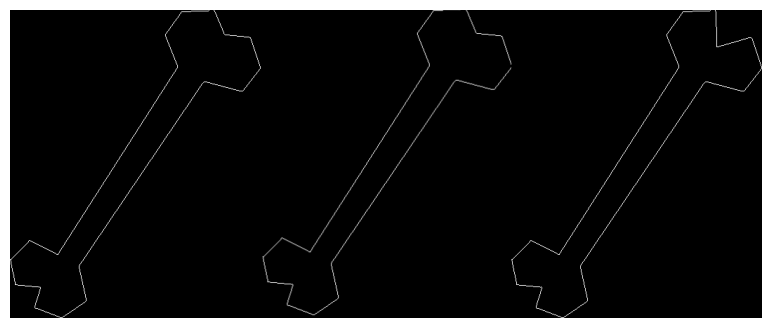

Error for Bone: 0.9051186996224818
Time taken for Bone: 0.009733915328979492 seconds


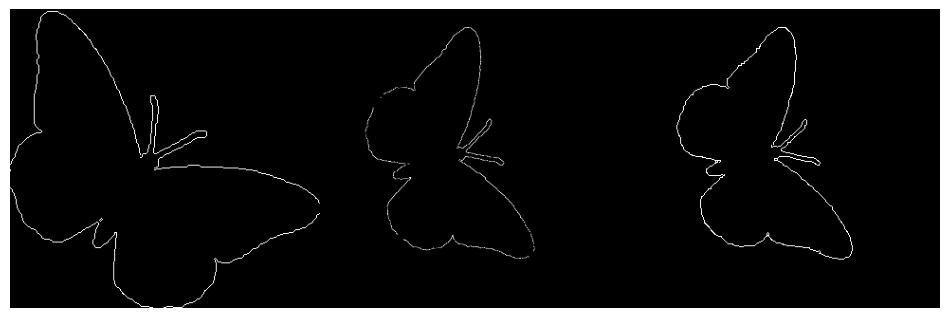

Error for butterfly: 1.5560773472530258
Time taken for butterfly: 0.024265289306640625 seconds


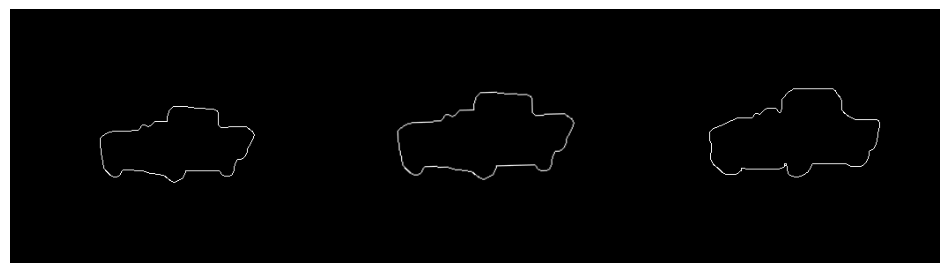

Error for car: 1.3319646093068642
Time taken for car: 0.005755901336669922 seconds


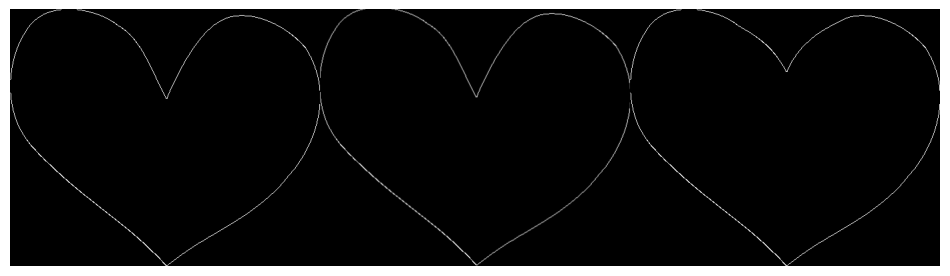

Error for Heart: 1.7295549635441365
Time taken for Heart: 0.006994962692260742 seconds


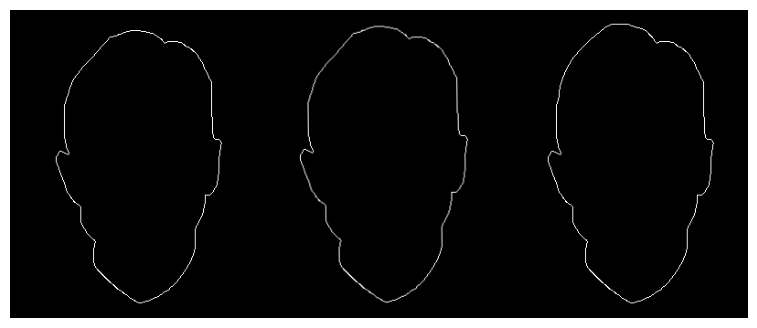

Error for face: 0.6828948912243619
Time taken for face: 0.010740041732788086 seconds


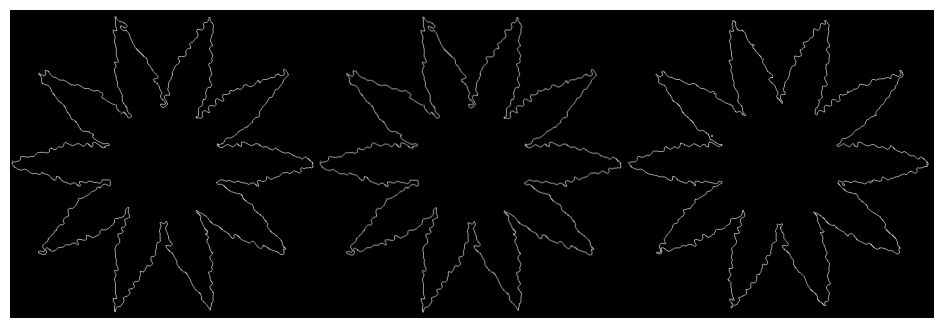

Error for device7: 0.7222528662241249
Time taken for device7: 0.009679317474365234 seconds


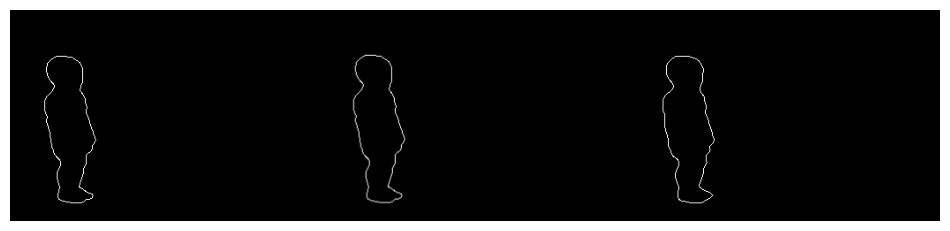

Error for children: 0.5092260312381919
Time taken for children: 0.002070188522338867 seconds


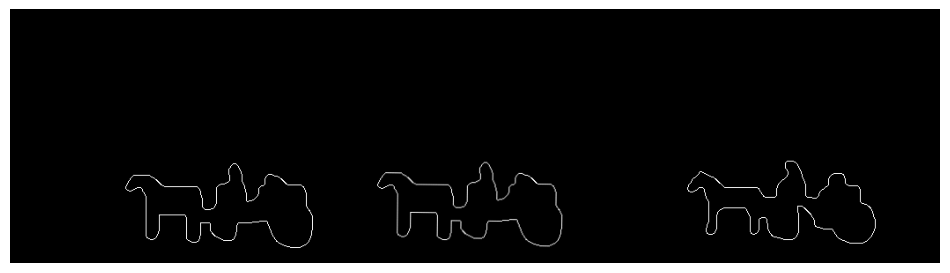

Error for carriage: 1.495174785392343
Time taken for carriage: 0.007099151611328125 seconds


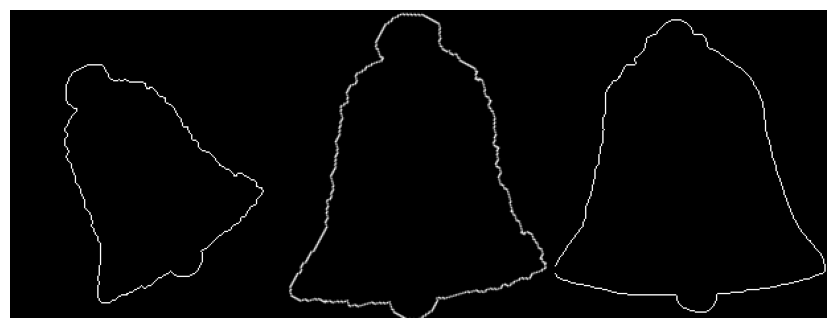

Error for bell: 2.6092074148011397
Time taken for bell: 0.019702911376953125 seconds


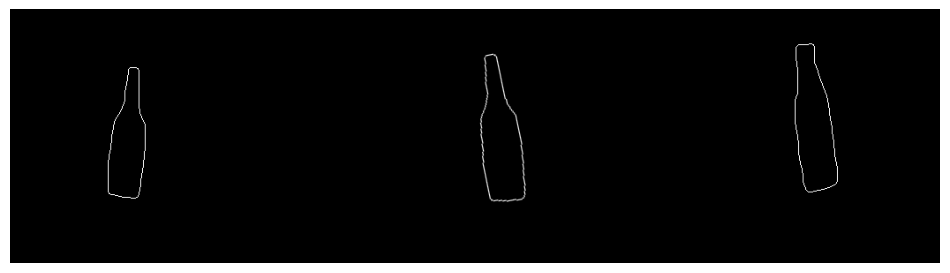

Error for bottle: 3.0795309099457606
Time taken for bottle: 0.005436897277832031 seconds


In [125]:
imgPath = 'part2_images/';

objList = [ 'Bone','butterfly',  'car', 'Heart','face', 'device7', 'children','carriage','bell','bottle']
numObj = len(objList)

# Add code to run align_shape() and display the results and the errors
for i in range(numObj):


    image_1 = imgPath + objList[i] + '_1.png'
    image_2 = imgPath + objList[i] + '_2.png'

    im1 = cv2.imread(image_1, cv2.IMREAD_GRAYSCALE)
    im2 = cv2.imread(image_2, cv2.IMREAD_GRAYSCALE)
    
    start_time = time.time()  
    T = align_shape(im1, im2)
    time_taken = time.time() - start_time 

    aligned1 = apply_transformation(im1, T)
    dispim = displayAlignment(im1, im2, aligned1) 

    plt.figure(figsize=(12, 4))  # Adjust the size as needed
    plt.imshow(dispim, cmap='gray')
    plt.axis('off')  # Hide the axis
    plt.show()
    # Compute error
    error = evalAlignment(normalize(aligned1), normalize(im2))
    print(f"Error for {objList[i]}: {error}")
    print(f"Time taken for {objList[i]}: {time_taken} seconds")

# Part 2: Object Instance Recognition (20 points)

## Overview
This problem explores the Lowe-style object instance recognition.

Implement the nearest neighbor distance ratio test using the pre-computed SIFT features SIFT_features.mat provided in the supplementary material. The Frame1, Frame2 indicate the 2D position, scales, and the orientation of the descriptors and Descriptor1, Descriptor2 are the correspondin 128-D SIFT features. Display the matches like this:

<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/Lowe_rec.jpeg" width="1000"/>



## Data

In [126]:
# # Download Data -- run this cell only one time per runtime
# !gdown 10ByzpFbB-z178VGjwmCwc95wInD8vpNM # SIFT Features
# !gdown 1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU # Stop sign image 1
# !gdown 13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J # Stop sign image 1

## Code (10 pts)

In [127]:
img1 = cv2.imread('stop1.jpg')
img2 = cv2.imread('stop2.jpg')

## inside the sift are:
## Descriptor1, Descriptor2: SIFT features from image 1 and image 2
## Frame1, Frame2: position, scale, rotation of keypoints
data = loadmat('SIFT_features.mat')
Frame1 = data['Frame1']
Descriptor1 = data['Descriptor1']
Frame2 = data['Frame2']
Descriptor2 = data['Descriptor2']

# print(Descriptor1)
# # print(Descriptor2.shape[1])

# YOUR CODE HERE

## matches: a 2 x N array of indices that indicates which keypoints from image
## 1 match which points in image 2


def find_match(descriptor1, descriptor2, ratio_threshold=0.77):
    dis_nearest = []
    ratio_nearest = []

    for i in range(descriptor1.shape[1]):
        sum_square_diff = []
        for j in range(descriptor2.shape[1]):
            sum_square_diff.append( np.sum((descriptor1[:,i] - descriptor2[:,j]) ** 2))
        
        first_nearest = np.min(sum_square_diff)
        index1 = np.argmin(sum_square_diff) 

        sum_square_diff[index1]= float('inf') # remove the 1st match

        second_nearst = np.min(sum_square_diff)

        if first_nearest < 3200:
            dis_nearest.append([i,index1])
        
        if first_nearest / second_nearst < ratio_threshold:
            ratio_nearest.append([i,index1])

    return dis_nearest, ratio_nearest

## Display the matched keypoints
# YOUR CODE HERE


def display(img1, img2, Frame1, Frame2, matches):
    height = max(img1.shape[0], img2.shape[0])
    width = img1.shape[1] + img2.shape[1]

    img1 = normalize(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    img2 = normalize(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

    combined_img = np.zeros((height, width, 3), dtype=np.float32)

    combined_img[:img1.shape[0], :img1.shape[1]] = img1
    combined_img[:img2.shape[0], img1.shape[1]:] = img2

    # Draw lines for each match
    for index1, index2 in matches:
        point1 = (int(Frame1[0, index1]), int(Frame1[1, index1]))
        point2 = (int(Frame2[0, index2]) + img1.shape[1], int(Frame2[1, index2]))
        cv2.line(combined_img, point1, point2, (0, 255, 0), 2)

    return combined_img

## Write-up (10 pts)

(5 pts) Display:

1. the matches by thresholding nearest neighbor distances.

2. the matches by thresholding the distance ratio.

(5 pts) Describe the differences of (1) and (2).

Marches by thresholding nearest neighbor distances will have more match to a similar interest point but it is not the point we want to match. It is more likely to match the second match(false match). However, matches by thresholding the distance ratio removed many matches that has small difference for first and second match. So it is more likely to match correct one but it the matches are more conservative.

**Your answer here**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


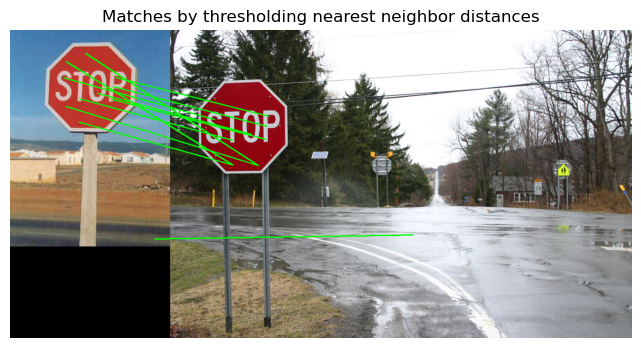

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


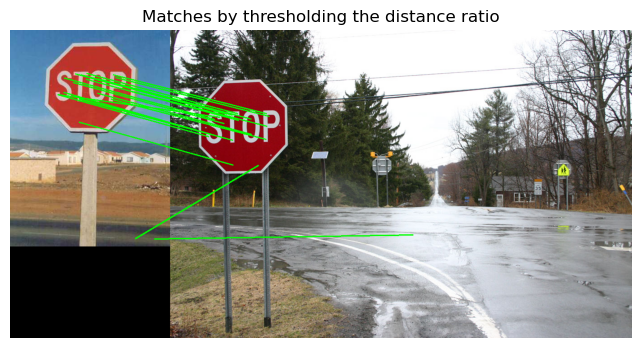

In [128]:
dist_match, ratio_match = find_match(Descriptor1, Descriptor2)
p1 = display(img1, img2, Frame1, Frame2, dist_match)
p2 = display(img1, img2, Frame1, Frame2, ratio_match)

plt.figure(figsize=(12, 4)) 
plt.imshow(p1, cmap='gray')
plt.title('Matches by thresholding nearest neighbor distances')
plt.axis('off')  
plt.show()

plt.figure(figsize=(12, 4)) 
plt.imshow(p2, cmap='gray')
plt.title('Matches by thresholding the distance ratio')
plt.axis('off')  
plt.show()